## Preprocessing MIDI Files

In [4]:
import collections
import glob
import pathlib
import pretty_midi
import pandas as pd
import numpy as np
import tensorflow as tf
from typing import Optional
from matplotlib import pyplot as plt

In [5]:
data_dir_c = pathlib.Path(r'../maestro-v2.0.0')
data_dir_p = pathlib.Path(r'../midi_dataset_pop')

filenames_c = glob.glob(str(data_dir_c/'**/*.mid*'))
filenames_p = glob.glob(str(data_dir_p/'**/*.mid*'))

print('Number of files Maestro:', len(filenames_c))
print('Number of files POP:', len(filenames_p))

Number of files Maestro: 1282
Number of files POP: 50


In [6]:
# analyzing and working with a sample file

sample_file_c = filenames_c[25]
sample_file_p = filenames_p[25]
print(sample_file_c)

pm = pretty_midi.PrettyMIDI(sample_file_c)

print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

# Extracting the notes
for i, note in enumerate(instrument.notes[:10]):
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    print(f'{i}: pitch={note.pitch}, note_name={note_name}, duration={duration:.4f}')

..\maestro-v2.0.0\2004\MIDI-Unprocessed_SMF_16_R1_2004_01-08_ORIG_MID--AUDIO_16_R1_2004_05_Track05_wav.midi
Number of instruments: 1
Instrument name: Acoustic Grand Piano
0: pitch=59, note_name=B3, duration=1.1927
1: pitch=44, note_name=G#2, duration=0.2188
2: pitch=51, note_name=D#3, duration=0.2667
3: pitch=63, note_name=D#4, duration=0.7646
4: pitch=56, note_name=G#3, duration=0.0396
5: pitch=68, note_name=G#4, duration=0.7937
6: pitch=64, note_name=E4, duration=0.8771
7: pitch=63, note_name=D#4, duration=0.1792
8: pitch=56, note_name=G#3, duration=0.1896
9: pitch=59, note_name=B3, duration=0.0646


In [7]:
# Extracting the notes from the sample MIDI file

def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

raw_notes = midi_to_notes(sample_file_c)
raw_notes.head()

,pitch,start,end,step,duration
0,59,1.040625,2.233333,0.000000,1.192708
1,68,1.702083,2.495833,0.661458,0.793750
2,63,1.711458,2.476042,0.009375,0.764583
3,44,2.111458,2.330208,0.400000,0.218750
4,51,2.130208,2.396875,0.018750,0.266667


['B3' 'G#4' 'D#4' 'G#2' 'D#3' 'G#3' 'E4' 'G#4' 'B4' 'D#4']


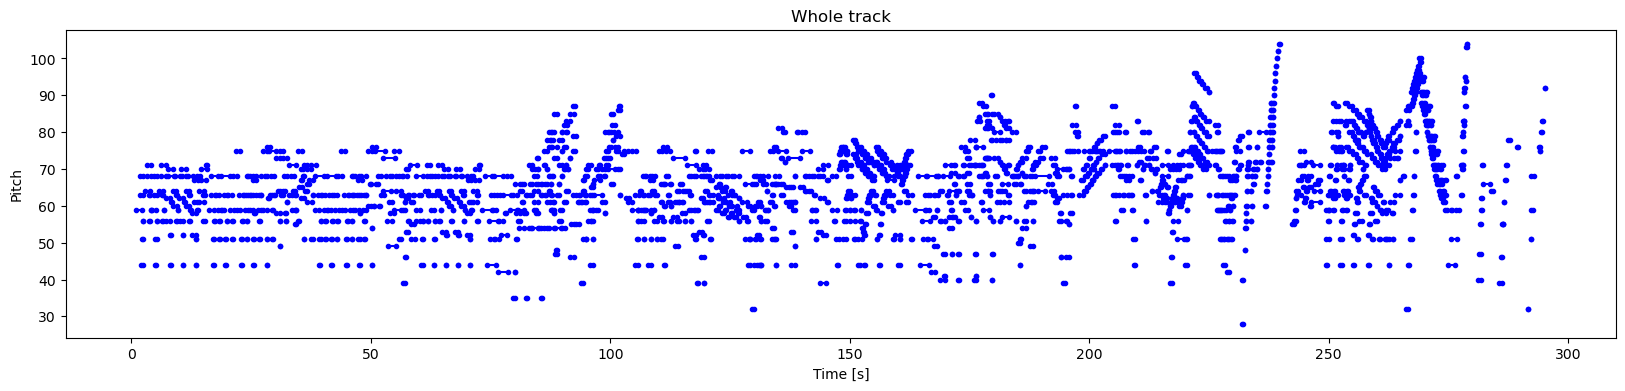

In [8]:
# Converting to note names by considering the respective pitch values

get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
print(sample_note_names[:10])

# Visualizing the paramaters of the muscial notes of the piano

def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if count:
        title = f'First {count} notes'
    else:
        title = f'Whole track'
        count = len(notes['pitch'])
        
        plt.figure(figsize=(20, 4))
        plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
        plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
        
        plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
        plt.xlabel('Time [s]')
        plt.ylabel('Pitch')
        _ = plt.title(title)

plot_piano_roll(raw_notes) 
plt.show()

In [9]:
# generate the musical score matrix
def create_pitch_time_matrix(df, time_resolution):

    max_pitch = df['pitch'].max()
    end_time = df['end'].max()

    matrix = np.zeros((max_pitch+1, int(end_time * time_resolution)))

    for _, row in df.iterrows():
        pitch = int(row['pitch'])
        start_time = int(row['start'] * time_resolution)
        end_time = int(row['end'] * time_resolution)
        matrix[pitch, start_time:end_time] = 1 

    return matrix

r = create_pitch_time_matrix(raw_notes,4)
c = r.size/8
r

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Dataset

In [22]:
num_files = 25
all_notes = []
for f in filenames_c[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)

n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

key_order = ['pitch', 'step', 'duration']
train_notes = all_notes

Number of notes parsed: 139455


In [36]:
# Dataset with intervall

def calc_intervallo(pitch1:int,pitch2:int):
    semitoni = (pitch2 - pitch1) % 12  # Usa il modulo per gestire le ottave

    return int(abs(semitoni))

def calc_diff(pitch1:int,pitch2:int)->int:
    ottave = pitch2 - pitch1
    ottave = ottave/12

    return int(ottave)

def create_intervall_data(df):
    notes = [] 
    rate = 16
    prev_note = df[0:1]
    for _, row in df.iterrows():
        intervall = calc_intervallo(prev_note['pitch'],row['pitch'])
        difference = calc_diff(prev_note['pitch'],row['pitch'])
        duration = int(row['duration']*rate)
        step = int(row['step']*rate)
        notes.append([intervall,difference,step,duration])
    return pd.DataFrame(notes,columns=['intervallo','diff','step','duration'])
df = create_intervall_data(train_notes)

seq_length = 10

dur_max = df['duration'].max()
int_max = df['intervallo'].max()
diff_max = df['diff'].max()
diff_mini = df['diff'].min()
step_max = df['step'].max()

#Dataset with pitches
def create_sequences(dataset, seq_length: int):
    seq_length = seq_length+1

    seq= []
    for i in range(len(df)-seq_length):
        seq.append(df.iloc[i:i+seq_length].values.tolist())

    return seq
data = create_sequences(df,seq_length)

df = pd.DataFrame(data)

C:\Users\cavas\AppData\Local\Temp\ipykernel_14192\4073299494.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(abs(semitoni))
C:\Users\cavas\AppData\Local\Temp\ipykernel_14192\4073299494.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(ottave)


In [18]:
import pickle
from sklearn.calibration import LabelEncoder

df_x = df[df.columns[:10]]
df_y = df[df.columns[-1:]]


print('Durata Massima '+str(dur_max))
print('Intervallo Massimo '+str(int_max))
print('Differenza Masima '+str(diff_max))
print('Differenza Minima '+str(diff_mini))
print('Step_massimo '+str(step_max))


with open("dataset.pkl", "wb") as f:
    pickle.dump(df_x, f)

with open("dataset_target.pkl", "wb") as f:
    pickle.dump(df_y, f)
df_y

Durata Massima 224
Intervallo Massimo 11
Differenza Masima 2
Differenza Minima -5
Step_massimo 265


,10
0,"[3, 0, 0, 1]"
1,"[1, 0, 0, 5]"
2,"[8, -1, 0, 1]"
3,"[7, -1, 2, 2]"
4,"[0, -1, 3, 1]"
...,...
139439,"[8, -3, 0, 0]"
139440,"[8, -4, 0, 1]"
139441,"[3, -2, 18, 0]"
139442,"[3, -3, 0, 0]"


## Dataset with pitch

In [13]:
#Dataset with pitches
num_files = 50
all_notes = []
for f in filenames_p[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)

n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)


notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)

notes_ds.element_spec

c:\Users\cavas\anaconda3\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Number of notes parsed: 6958


TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [14]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)


## Dataset Multi Genre

In [15]:
num_files = 25

all_notes = []
for f in filenames_c[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

for f in filenames_p[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)

n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

key_order = ['pitch', 'step', 'duration']
train_notes = all_notes

KeyboardInterrupt: 

In [ ]:
def notes_to_midi(notes: pd.DataFrame, out_file: str, instrument_name: str,
                  velocity: int = 100) -> pretty_midi.PrettyMIDI:

    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        
        note = pretty_midi.Note(velocity=velocity, pitch=int(note['pitch']),
                                start=start, end=end)
        instrument.notes.append(note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)